In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

"""
이전 CNN 실습에서는 CIFAR10 데이터를 일일이 다 다운받아서 loading 후에 setting하는 과정까지 다했기에 이번에는 라이브러리를 이용해서 수행했습니다.
CIFAR10 데이터는 칼라 이미지 데이터로 RGB 채널을 고려해야하지만 이를 grayscale 이미지로 변환하는 과정을 거쳐서 기본 세팅을 했습니다.
칼라이미지를 흑백이미지로 변환한 후에 학습을 진행하다보니 최종 이미지 결과는 그리 좋지 못해서 추가적인 처리과정이 필요해보였으나 Discriminator와 Generator의 loss가 계속해서 학습하는 과정을 확인했습니다.
Discriminator와 Generator의 loss가 일정 수에 수렴하지 않고 지속적으로 변화되는 것을 보아 아무래도 학습을 더 진행하면 더 좋은 결과를 얻을 것으로 예상이 됩니다.
이는 방학을 이용해서 추가적으로 실습을 심화해서 해보면 좋을 것이라고 생각이들었습니다.

따라서 이번 실습 과제에서는 load_dataset() 함수와 일부 클래스 이름만 수정해서 진행했습니다.
사실상 중요한 부분은 load_dataset() 함수입니다.
"""

Mounted at /gdrive


'\n이전 CNN 실습에서는 CIFAR10 데이터를 일일이 다 다운받아서 loading 후에 setting하는 과정까지 다했기에 이번에는 라이브러리를 이용해서 수행했습니다.\nCIFAR10 데이터는 칼라 이미지 데이터로 RGB 채널을 고려해야하지만 이를 grayscale 이미지로 변환하는 과정을 거쳐서 기본 세팅을 했습니다.\n칼라이미지를 흑백이미지로 변환한 후에 학습을 진행하다보니 최종 이미지 결과는 그리 좋지 못해서 추가적인 처리과정이 필요해보였으나 Discriminator와 Generator의 loss가 계속해서 학습하는 과정을 확인했습니다. \nDiscriminator와 Generator의 loss가 일정 수에 수렴하지 않고 지속적으로 변화되는 것을 보아 아무래도 학습을 더 진행하면 더 좋은 결과를 얻을 것으로 예상이 됩니다.\n이는 방학을 이용해서 추가적으로 실습을 심화해서 해보면 좋을 것이라고 생각이들었습니다.\n\n따라서 이번 실습 과제에서는 load_dataset() 함수와 일부 클래스 이름만 수정해서 진행했습니다.\n사실상 중요한 부분은 load_dataset() 함수입니다.\n'

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)

# computer vision 관련된 pytorch 라이브러리
import torchvision
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

from keras.datasets import cifar10

#Vanila GAN으로 손글씨 생성하는 프로그램
#GAN은 초기값과 디자인된 모델에 영향을 많이 받는 단점이 있음.

################################
#      Discriminator 설계      #
################################

class CIFAR10_Discriminator(nn.Module):

  def __init__(self, config):
    #생성자 override
    super(CIFAR10_Discriminator, self).__init__()

    # 입력층 노드 수
    self.inode = config["d_input_node"]
    # 은닉층 노드 수
    self.hnode = config["d_hidden_node"]
    # 출력층 노드 수: 분류해야 하는 레이블 수 => fake or real ==> 0 or 1
    self.onode = config["d_output_node"]

    # 신경망 설계
    self.net = nn.Sequential(nn.Linear(self.inode, self.hnode, bias=True),
                             nn.LeakyReLU(),#hidden node에 LeakyReLU
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.onode, bias=True),
                             nn.Sigmoid())#output node에 sigmoid로 0~1로 출력

  def forward(self, input_features):
    #forward override
    hypothesis = self.net(input_features)
    return hypothesis

################################
#        Generator 설계        #
################################

class CIFAR10_Generator(nn.Module):

  def __init__(self, config):
    #생성자 override
    super(CIFAR10_Generator, self).__init__()

    # 입력층 노드 수 -> 입력 노드는  32*32보다 작은 noise z
    self.inode = config["g_input_node"]
    # 은닉층 노드 수
    self.hnode = config["g_hidden_node"]
    # 출력층 노드 수: 생성해야 하는 노드 수 -> 출력도 이미지 생성을 위한 32*32
    self.onode = config["g_output_node"]

    # 신경망 설계
    self.net = nn.Sequential(nn.Linear(self.inode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.onode, bias=True),
                             nn.Tanh())#Generator의 output node에는 Tanh 결과가 [-1 1]이라 imshow_grid()에서 보정

  def forward(self, input_features):
    #forward override
    hypothesis = self.net(input_features)
    return hypothesis

In [3]:
def imshow_grid(img):
  #해당 이미지를 보여주는 함수
  #이미지를 2*8의 grid 형식으로 보여줌
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    #tanh로 인해서 [-1 1]의 범위를 [0 1]의 범위로 조정
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    #2차원으로 변형
    plt.show()

In [4]:
"""
이전 CNN 실습에서는 CIFAR10 데이터를 일일이 다 다운받아서 loading 후에 setting하는 과정까지 다했기에 이번에는 라이브러리를 이용해서 수행했습니다.
CIFAR10 데이터는 칼라 이미지 데이터로 RGB 채널을 고려해야하지만 이를 grayscale 이미지로 변환하는 과정을 거쳐서 기본 세팅을 했습니다.
칼라이미지를 흑백이미지로 변환한 후에 학습을 진행하다보니 최종 이미지 결과는 그리 좋지 못해서 추가적인 처리과정이 필요해보였으나 Discriminator와 Generator의 loss가 계속해서 학습하는 과정을 확인했습니다.
Discriminator와 Generator의 loss가 일정 수에 수렴하지 않고 지속적으로 변화되는 것을 보아 아무래도 학습을 더 진행하면 더 좋은 결과를 얻을 것으로 예상이 됩니다.
이는 방학을 이용해서 추가적으로 실습을 심화해서 해보면 좋을 것이라고 생각이들었습니다.

따라서 이번 실습 과제에서는 load_dataset() 함수와 일부 클래스 이름만 수정해서 진행했습니다.
사실상 중요한 부분은 load_dataset() 함수입니다.
"""

def load_dataset():
    transforms, datasets

    # 정규화와 채널 선택을 위한 변환 정의
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.mean(x, dim=0, keepdim=True)),  # RGB 채널의 평균을 구해 채널을 1로 만듦
        transforms.Normalize((0.5, ), (0.5,))
    ])

    # CIFAR-10 데이터셋 로드
    cifar_dataset = datasets.CIFAR10(root='/gdrive/MyDrive/Colab/Week14/GAN/CIFAR10/data', train=True, download=True, transform=transform)

    return cifar_dataset


In [6]:
def get_noise(batch_size=16, g_input_node=100): #해당 batch size만큼 g의 input 데이터를 개수만큼 랜덤 noise로 생성
    return torch.randn(batch_size, g_input_node)

def do_test(model, input_node):
  # 평가 모드 셋팅
  model.eval()

  with torch.no_grad():

    X = get_noise(g_input_node=input_node).cuda()
    hypothesis = model(X)
    #hypothesis는 32*32 데이터
    hypothesis_ = hypothesis.reshape((-1,32,32)).unsqueeze(1)
    #2차원으로 바꾸기
    imshow_grid(hypothesis_)

In [7]:
# 모델 학습 함수
# 생성만 하기에 test는 없음
def train(config):

  # Discriminator와 Generator 모델 생성
  # 이곳을 채우세요.
  D = CIFAR10_Discriminator(config).cuda()
  G = CIFAR10_Generator(config).cuda()

  # 데이터 읽기
  input_features = load_dataset()

  # DataLoader를 통해 배치(batch) 단위로 데이터를 나누고 셔플(shuffle)
  train_dataloader = DataLoader(input_features, shuffle=True, batch_size=config["batch_size"])
  # 바이너리 크로스엔트로피 비용 함수
  loss_func = nn.BCELoss()

  # Discriminator와 Generator 옵티마이저 함수 지정
  # 이곳을 채우세요.
  D_optimizer = torch.optim.Adam(D.parameters(), lr=config["learn_rate"])
  G_optimizer = torch.optim.Adam(G.parameters(), lr=config["learn_rate"])

  for epoch in range(config["epoch"]+1):

    # Discriminator와 Generator 학습 모드 셋팅
    D.train()
    G.train()

    # epoch 마다 평균 비용을 저장하기 위한 리스트
    D_costs, G_costs = [], []
    for (step, batch) in enumerate(train_dataloader):

      # batch = (input_features[step], labels[step])*batch_size
      # .cuda()를 통해 메모리에 업로드
      batch = tuple(t.cuda() for t in batch)

      # 배치 크기 만큼 입력 데이터 읽기
      input_features, _ = batch # _ 부분은 layer인데 필요는 없음
      input_features = input_features.view(-1,config['d_input_node'])
      # input_features가 batch 단위로 들어옴. 행이 batch니까 -1로 설정해서 view()를 구성 config['d_input_node']를 1차원으로 변형


      ################################
      #      Discriminator 학습      #
      ################################

      # 역전파 변화도 초기화
      D_optimizer.zero_grad()

      # 진짜에 대한 비용 계산
      real_hypothesis = D(input_features) #real이면 1
      real_labels = Variable(torch.ones(config["batch_size"],1)).cuda()#1이 batch size만큼 1이 들어감
      real_cost = loss_func(real_hypothesis, real_labels)

      # 가짜에 대한 비용 계산
      fake_input_features = get_noise(config["batch_size"],config["g_input_node"]).cuda()
      fake_hypothesis = D(G(fake_input_features))#Generator가 Discriminator의 입력으로 들어감
      fake_labels = Variable(torch.zeros(config["batch_size"],1)).cuda() #0이 batch size만큼 0이 들어감
      fake_cost = loss_func(fake_hypothesis, fake_labels)

      # 전체 비용 역전파 수행

      # 이곳을 채우세요.
      total_cost = real_cost + fake_cost
      total_cost.backward()
      D_optimizer.step()

      # 현재 batch의 스텝 별 Discrimnator 비용 저장
      D_costs.append(total_cost.data.item())

      ################################
      #        Generator 학습        #
      ################################

      # 역전파 변화도 초기화
      G_optimizer.zero_grad()

      # 가짜에 대한 비용 계산
      fake_input_features = get_noise(config["batch_size"],config["g_input_node"]).cuda()
      # 이곳을 채우세요.
      fake_hypothesis = D(G(fake_input_features))
      fake_labels = Variable(torch.ones(config["batch_size"],1)).cuda()
      # 이곳을 채우세요.
      fake_cost = loss_func(fake_hypothesis, fake_labels)

      # 가짜 생성 비용 역전파 수행
      fake_cost.backward()
      G_optimizer.step()

      # 현재 batch의 스텝 별 Generator 비용 저장
      G_costs.append(fake_cost.data.item())

    # 10 에폭마다 중간 결과 출력 및 저장
    if epoch%10 == 0:

      # 평균 비용 출력
      print("Avg Loss D={0:f}, Avg Loss G={1:f}".format(np.mean(D_costs), np.mean(G_costs)))

      # Generator 저장
      torch.save(G.state_dict(), os.path.join(config["output_dir"], "epoch_{0:d}.pt".format(epoch)))

      # 생성된 샘플 출력
      do_test(G,config['g_input_node'])


Files already downloaded and verified
Avg Loss D=0.264187, Avg Loss G=5.368057


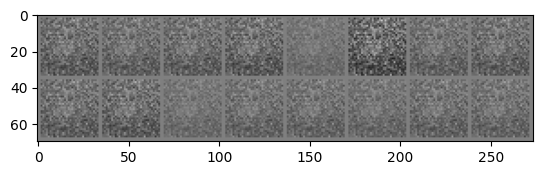

Avg Loss D=0.257405, Avg Loss G=3.900935


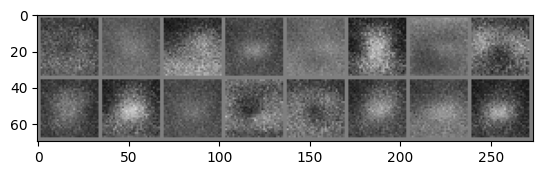

Avg Loss D=0.552957, Avg Loss G=2.816982


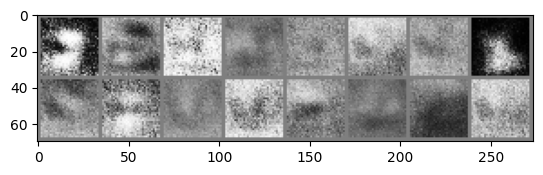

Avg Loss D=0.766846, Avg Loss G=1.935702


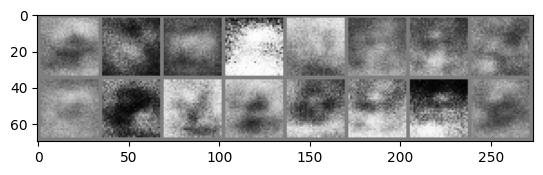

Avg Loss D=1.010299, Avg Loss G=1.358809


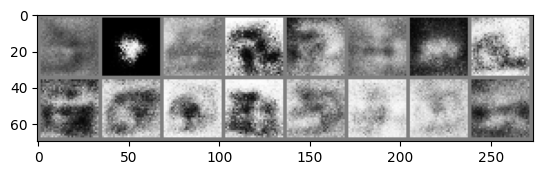

Avg Loss D=1.157513, Avg Loss G=1.060346


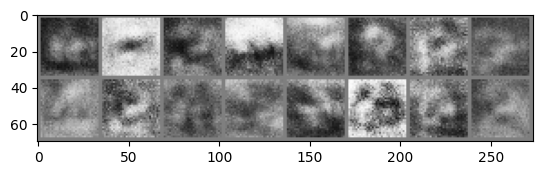

Avg Loss D=1.225954, Avg Loss G=0.947985


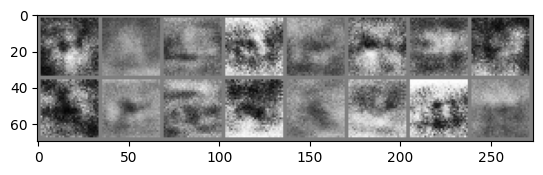

Avg Loss D=1.253065, Avg Loss G=0.897867


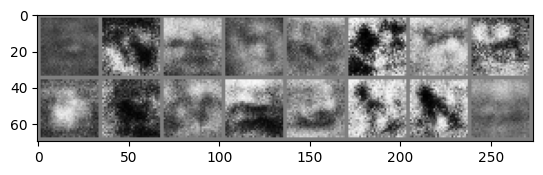

Avg Loss D=1.276830, Avg Loss G=0.867879


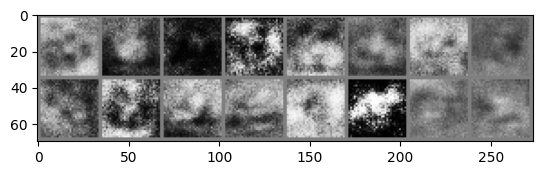

Avg Loss D=1.302015, Avg Loss G=0.833333


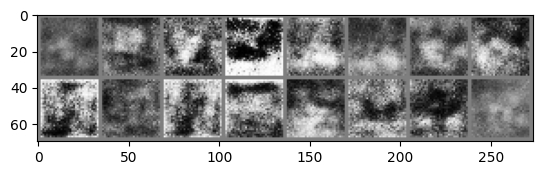

Avg Loss D=1.298970, Avg Loss G=0.825596


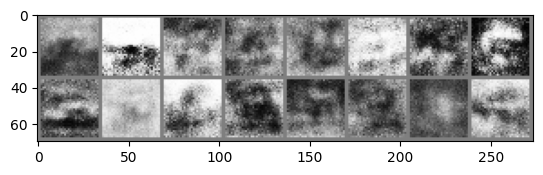

In [8]:
if(__name__=="__main__"):

    root_dir = "/gdrive/MyDrive/Colab/Week14/GAN/CIFAR10"
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config = {"model_name":"epoch_{0:d}.pt".format(10),
              "root_dir":root_dir,
              "output_dir":output_dir,
              "d_input_node":32*32, #32*32
              "d_hidden_node":256,
              "d_output_node":1,
              "g_input_node":100, #32*32 보다 작음
              "g_hidden_node":256,
              "g_output_node":32*32, #G의 output은 32*32
              "learn_rate":0.0002,
              "batch_size":100,
              "epoch":100,
              }

    train(config)

    """
이전 CNN 실습에서는 CIFAR10 데이터를 일일이 다 다운받아서 loading 후에 setting하는 과정까지 다했기에 이번에는 라이브러리를 이용해서 수행했습니다.
CIFAR10 데이터는 칼라 이미지 데이터로 RGB 채널을 고려해야하지만 이를 grayscale 이미지로 변환하는 과정을 거쳐서 기본 세팅을 했습니다.
칼라이미지를 흑백이미지로 변환한 후에 학습을 진행하다보니 최종 이미지 결과는 그리 좋지 못해서 추가적인 처리과정이 필요해보였으나 Discriminator와 Generator의 loss가 계속해서 학습하는 과정을 확인했습니다.
Discriminator와 Generator의 loss가 일정 수에 수렴하지 않고 지속적으로 변화되는 것을 보아 아무래도 학습을 더 진행하면 더 좋은 결과를 얻을 것으로 예상이 됩니다.
이는 방학을 이용해서 추가적으로 실습을 심화해서 해보면 좋을 것이라고 생각이들었습니다.

따라서 이번 실습 과제에서는 load_dataset() 함수와 일부 클래스 이름만 수정해서 진행했습니다.
사실상 중요한 부분은 load_dataset() 함수입니다.
"""